In [12]:
from analysis.analysis import *
import matplotlib.pyplot as plt


root = "defaults"
gid = 141
default_LC_gid = 10

Read the raw sim data for a grid ID

In [13]:
grid_df = read_fulltake(
    f"../_server/sim_data/{root}/parquets/fulltake_gid{gid}.parquet",
    scale_position=True,
)

grid_df.rid.unique().size

2400

Histogram of hopping times _vs._ default limit-cycle cell

In [14]:
try:
    plt.figure(figsize=(3, 2), dpi=100)
    plt.hist(
        np.load(f"../_server/sim_data/{root}/hopping times/fulltake_gid{gid}.npy"),
        density=True,
        bins=40,
        alpha=0.75,
        color="cornflowerblue",
        label=f"Grid {gid}",
    )
    plt.hist(
        np.load(f"../_server/sim_data/{root}/hopping times/fulltake_gid{10}.npy"),
        density=True,
        bins=40,
        alpha=0.75,
        color="salmon",
        label=f"Grid {default_LC_gid}",
    )
    plt.xlabel("Hopping times (hr)")
    plt.legend()
    plt.show()
except FileNotFoundError:
    print("Make sure to first run compute_hopping_times.py")

Make sure to first run compute_hopping_times.py


<Figure size 300x200 with 0 Axes>

Apply a time filter (min) to raw data and compute $x, v, a$
- Sims collect at a rate of 3 min

In [15]:
grid_df = apply_time_filter(grid_df, dt=3, base_rate=3)

nbins = 31
xva_df = get_xva_df(
    grid_df,
    nbins,
    yfile=f"../_server/sim_data/{root}/configs/grid_id{gid}/simbox.yaml",
)

Plot of $F(x, v)$ with streamlines and $\sigma(x, v)$

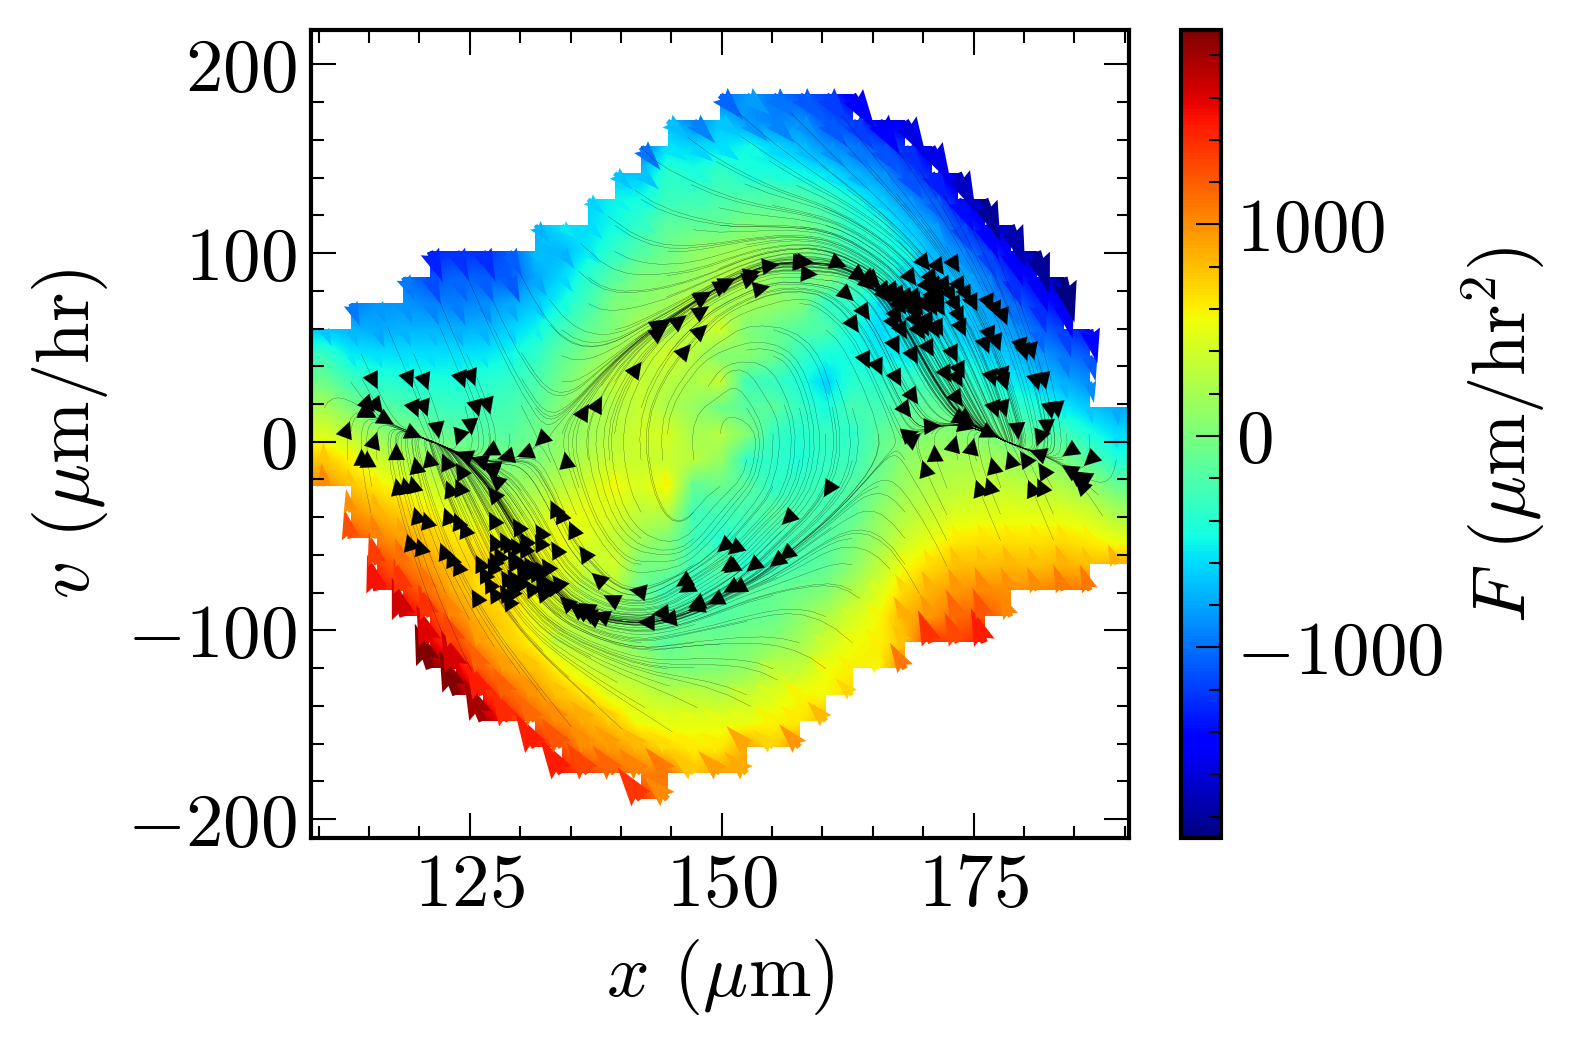

In [16]:
bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=10)

xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]
bounds_tup = (xmin, xmax, vmin, vmax, nbins)

plot_title = make_title(xva_df)
title = {"label": plot_title, "fontsize": 20}

init_pts = linear_lattice(xmin, xmax, vmin, vmax, n_pts=100, s=1.)
fig, ax = plt.subplots(1, 2, figsize=(11, 3.5), dpi=300)

X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)

ax[0].set_title(**title)
F_streamplot(
    F,
    bounds_tup,
    stream_init_pts=init_pts[::2],
    imshow_kwargs={"interpolation": "bilinear", "origin": "lower", "cmap": "jet"},
    streamplot_kwargs={
        "integration_direction": "forward",
        "color": "black",
        "broken_streamlines": False,
        "density": 1,
        "linewidth": 0.05,
    },
    do_try=True,
    ax=ax[0],
)
# ax[0].scatter(init_pts[:, 0], init_pts[:, 1])

im = ax[1].imshow(
    sigma,
    extent=[xmin, xmax, vmin, vmax],
    interpolation="bilinear",
    origin="lower",
    cmap="viridis",
)

# ax[0].scatter(init_pts[:, 0], init_pts[:, 1], s=5, color="red")
# ax[1].set_xlabel(r"$x$ ($\mu$m)")
# ax[1].set_ylabel(r"$v$ ($\mu$m/hr)")
# cbar = plt.colorbar(im, ax=ax[1])
# cbar.set_label(r"$\sigma$ ($\mu$m/hr$^{-3/2}$)")
# ax[1].set_aspect("auto")
ax[1].remove()

ax[0].set_title("")

plt.subplots_adjust(wspace=0.5)
plt.show()

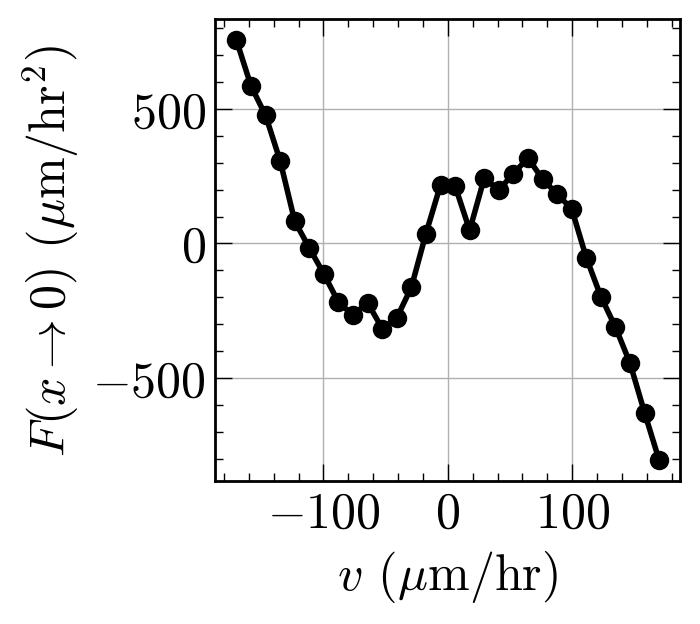

In [17]:
X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)

# raw
v, f = evaluate_F_v_x0(Y, F, nbins)
lim = np.fabs([v.min(), v.max()]).min()
v_interp = np.linspace(-lim, lim, 30)
f_interp = np.interp(v_interp, v, f)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
ax.plot(v_interp, f_interp, "-o", lw=2, color="black")
ax.grid(which="major")
ax.set_xlabel(r"$v$ ($\mu$m/hr)")
ax.set_ylabel(r"$F(x\rightarrow 0)$ ($\mu$m/hr$^2$)")
plt.show()

Phase separation for bistable cases

In [18]:
labels = get_labels(init_pts, X, Y, F)
set(labels)

TypeError: unhashable type: 'list'

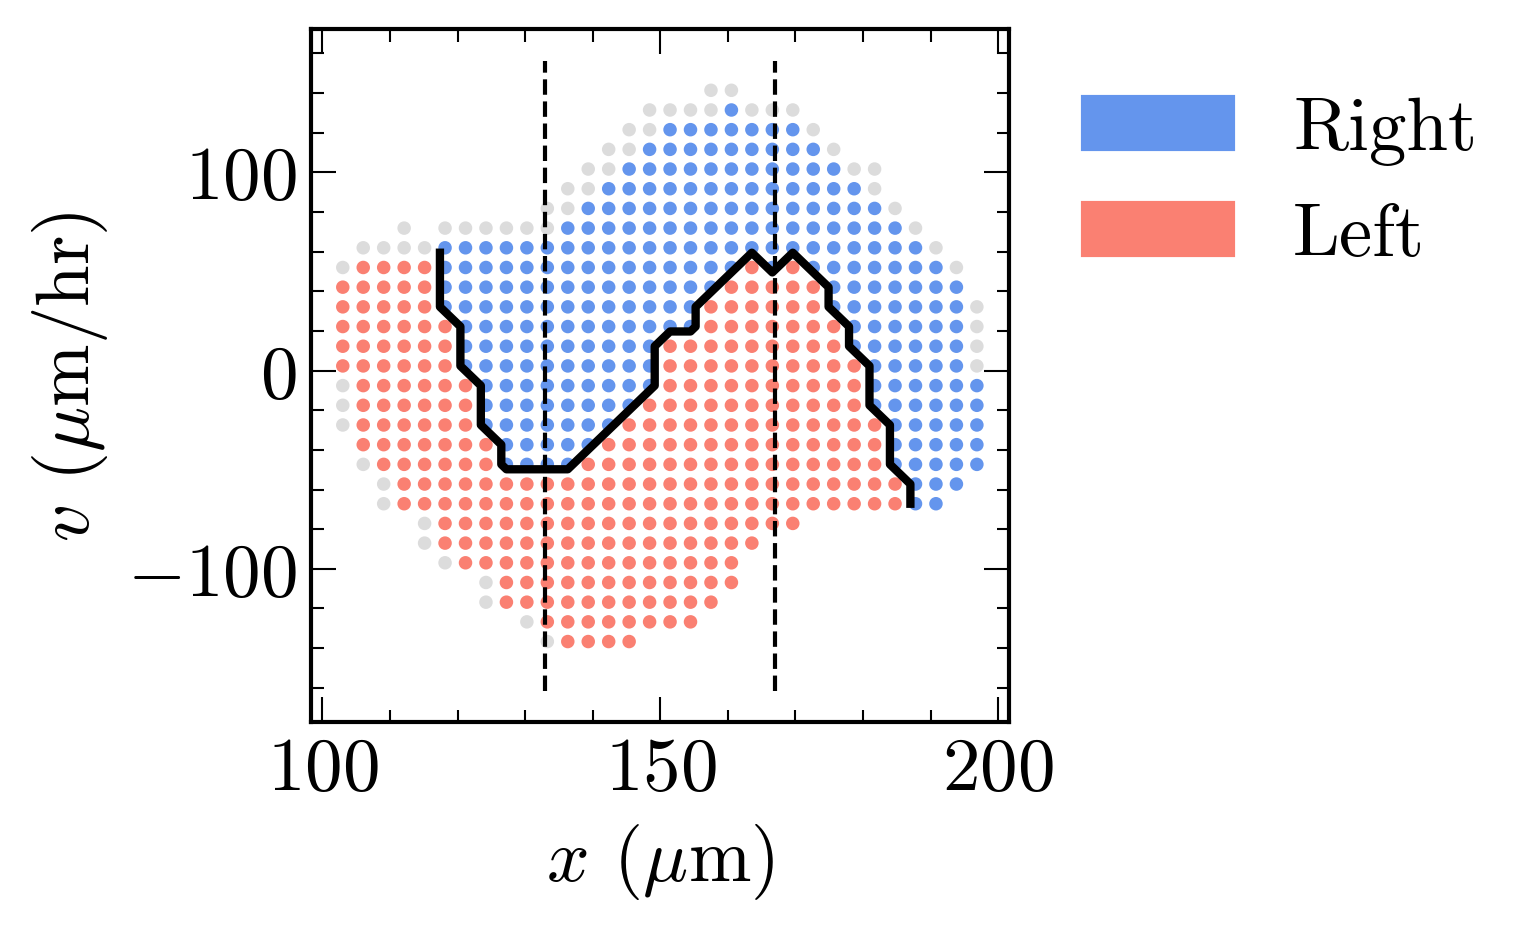

In [ ]:
img = lattice_to_image(init_pts, labels, bounds_tup)
X = get_separatrices(img, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax])

# plot
plt.figure(figsize=(3, 3), dpi=300)
plt.vlines(
    x=133, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)
plt.vlines(
    x=167, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)

plt.scatter(init_pts[:, 0], init_pts[:, 1], color=labels, s=5)
plt.plot(X[:, 0], X[:, 1], lw=2, color="black")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
xlim = plt.xlim()
ylim = plt.ylim()

# Add fancy legends
import matplotlib.patches as mpatches

legend_dict = {
    "salmon": mpatches.Patch(color="salmon", label="Left"),
    "cornflowerblue": mpatches.Patch(color="cornflowerblue", label="Right"),
    "wheat": mpatches.Patch(color="wheat", label="Middle"),
}
legend = []
for c in np.unique(labels):
    legend.append(legend_dict[c]) if c != "gainsboro" else None
plt.legend(handles=legend, bbox_to_anchor=(1.01, 1))
plt.show()

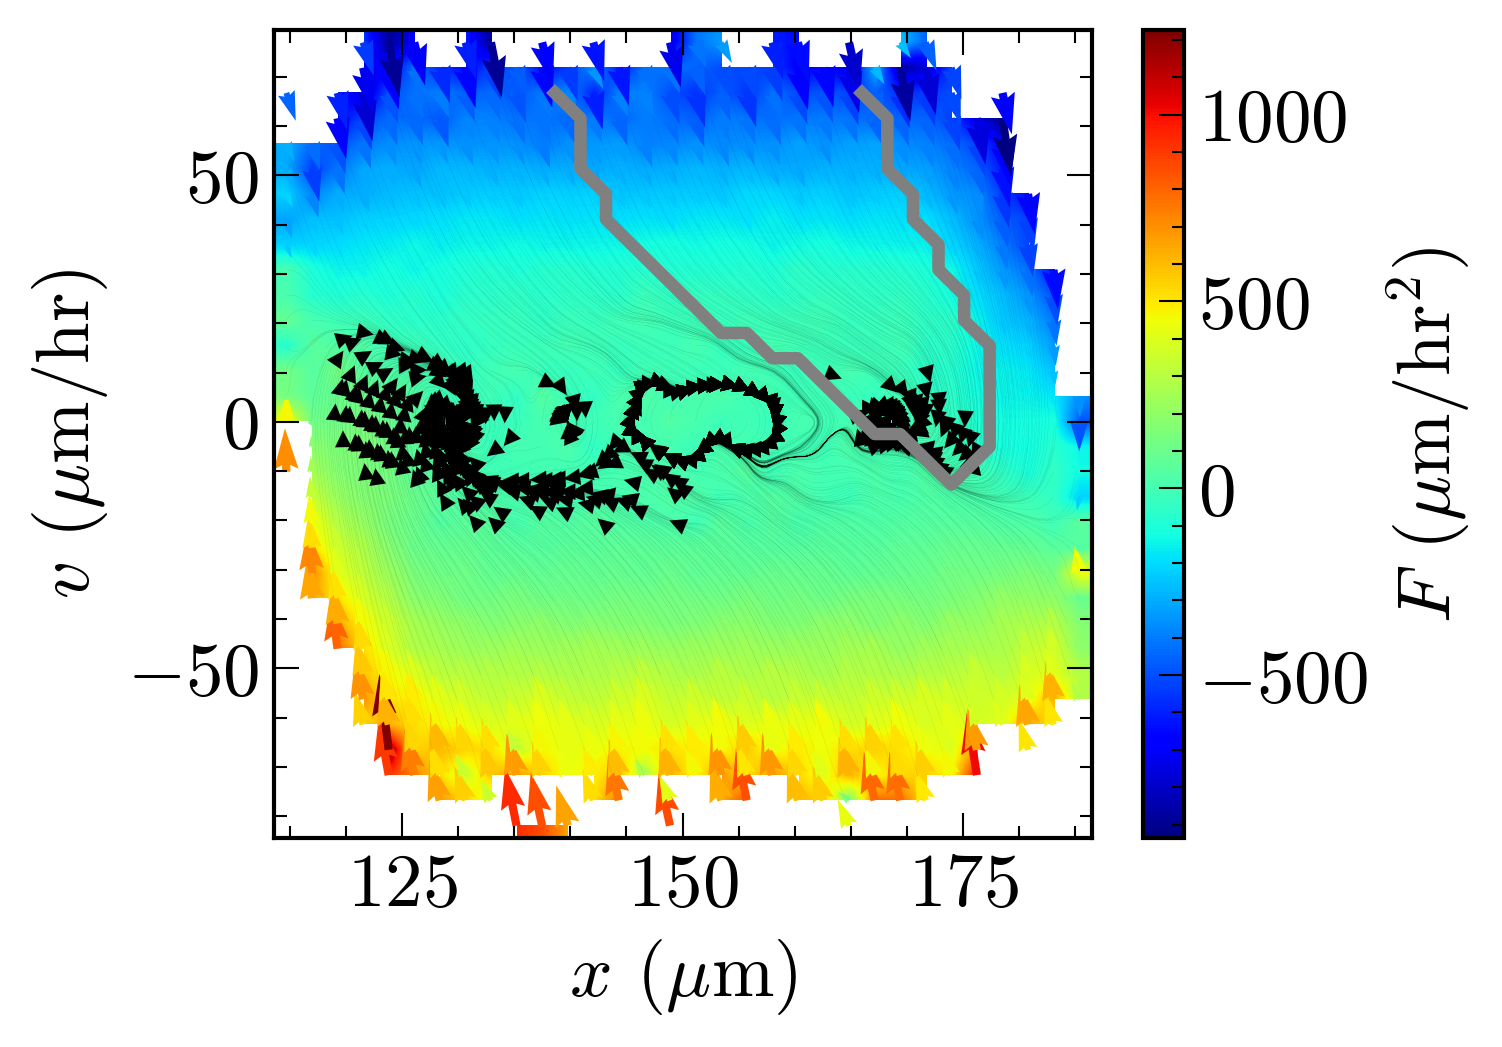

In [10]:
bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=1)

xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]
bounds_tup = (xmin, xmax, vmin, vmax, nbins)

plot_title = make_title(xva_df)
title = {"label": plot_title, "fontsize": 20}

fig, ax = plt.subplots(1, 2, figsize=(11, 3.5), dpi=300)

ax[0].set_title(**title)
F_streamplot(
    F,
    bounds_tup,
    stream_init_pts=init_pts,
    imshow_kwargs={"interpolation": "bilinear", "origin": "lower", "cmap": "jet"},
    streamplot_kwargs={
        "integration_direction": "forward",
        "color": "black",
        "broken_streamlines": False,
        "density": 1,
        "linewidth": 0.01,
    },
    do_try=False,
    ax=ax[0],
)

ax[0].plot(X[:, 0], X[:, 1], lw=3, color="grey")

im = ax[1].imshow(
    sigma,
    extent=[xmin, xmax, vmin, vmax],
    interpolation="bilinear",
    origin="lower",
    cmap="viridis",
)


ax[1].remove()
ax[0].set_title("")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [11]:
(xmax - xmin)/32, (vmax - vmin)/32

(2.2785462981090596, 5.124994425928682)

---

(75.0, 125.0)

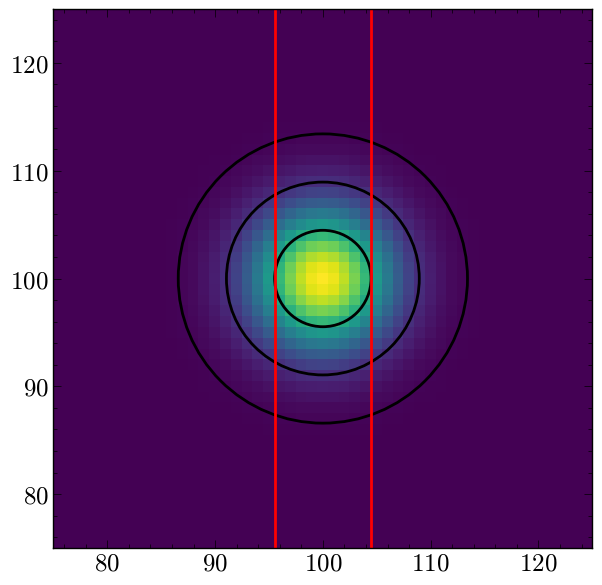

In [12]:
from polarity.mvgaussian import MVGaussian
from matplotlib import patches
import numpy as np
import matplotlib.pyplot as plt

N = 200
L = 50
dx = L / (N - 1)
d = np.arange(N)
x, y = np.meshgrid(d, d)
X = np.array(list(zip(x.flatten(), y.flatten())))

sigma_sqrd = 20

plt.figure(figsize=(7, 7))
plt.imshow(
    MVGaussian(X).pdf([100, 100], sigma_sqrd * np.array([[1, 0], [0, 1]])).reshape(N, N)
)
ells = [
    patches.Ellipse(
        [100, 100],
        width=s * 2 * np.sqrt(sigma_sqrd),
        height=s * 2 * np.sqrt(sigma_sqrd),
        fill=False,
        lw=2,
    )
    for s in [1, 2, 3]
]
[plt.gca().add_patch(ell) for ell in ells]
d = 25

plt.vlines(
    [100 - np.sqrt(sigma_sqrd), 100 + np.sqrt(sigma_sqrd)],
    *plt.ylim(),
    lw=2,
    color="red"
)
plt.xlim((100 - d, 100 + d))
plt.ylim((100 - d, 100 + d))

In [13]:
np.sqrt(sigma_sqrd) * dx * 6

6.741913499999365

# Plots for Paper

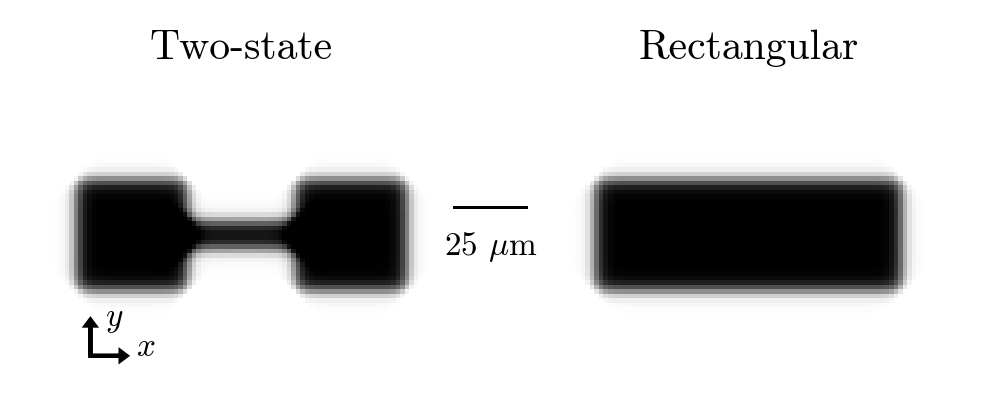

In [14]:
from substrate.substrates import Substrate
import matplotlib.pyplot as plt

sub_gen = Substrate(200, 50)
rect = sub_gen.rectangular()

ext = 0
l = 38 + ext
d = 73 + ext
ts = sub_gen.two_state_sub(square_width=l, delta_centers=d)

# fig, ax = plt.subplot_mosaic([[0, 1], [2, 2]], figsize=(3, 2), dpi=300)
fig, ax = plt.subplots(1, 2, figsize=(4, 2), dpi=300)

for a, im, title in zip(ax, [ts, rect], ["Two-state", "Rectangular"]):
    alpha = 0 if title == "" else 1
    a.imshow(im, extent=[0, 50 * 6, 0, 50 * 6], cmap="Greys_r", alpha=alpha)
    # a.contour(im, levels=[0.5], linewidths=[1], colors=["cornflowerblue"], extent=[0, 50 * 6, 0, 50 * 6])
    a.set_xlim([80, 220])
    a.set_ylim([100, 200])
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.set_frame_on(False)
    a.set_title(title, fontsize=10)

    if title == "Two-state":
        a.arrow(
            100,
            110,
            10,
            0,
            width=0.001,
            head_width=3,
            head_length=2,
            color="black",
        )
        a.arrow(
            100,
            110,
            0,
            10,
            width=0.001,
            head_width=3,
            head_length=2,
            color="black",
        )
        a.text(115, 110, r"$x$", {"fontsize": 8})
        a.text(105, 120, r"$y$", {"fontsize": 8})


from matplotlib_scalebar.scalebar import ScaleBar

scalebar = ScaleBar(
    dx=1,
    units="um",
    location="center left",
    pad=-1.25,
    border_pad=0,
    box_alpha=0,
    font_properties={"size": 8},
)
a.add_artist(scalebar)

plt.savefig("paper_plots/geometries.pdf")
plt.show()